# 데이터셋 - 훈련용/테스트용 한 세트의 데이터셋 --> 편향현상 발생 가능.
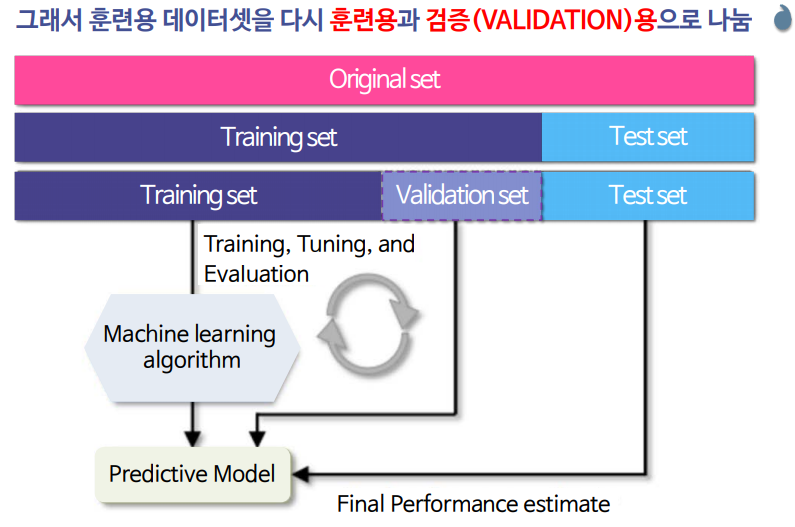


In [67]:
import pandas as pd

titanic = pd.read_excel('./titanic.xls')
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [68]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder() #LabelEncoder -> 문자를 숫자로 바꾸는 인코딩 기능과 숫자를 문자로 바꾸는 디코딩 기능을 제공해줄 수 있다.
le.fit(titanic['sex']) 

titanic['gender'] = le.transform(titanic['sex']) # sex 문자열을 정수값으로 변형하여 새로운 col을 추가.
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,gender
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",0
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",1
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",0
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",1
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",0


In [69]:
# 비어있는 데이터 걸러내기
titanic = titanic[titanic['age'].notnull()]
titanic = titanic[titanic['fare'].notnull()]
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1045 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1045 non-null   int64  
 1   survived   1045 non-null   int64  
 2   name       1045 non-null   object 
 3   sex        1045 non-null   object 
 4   age        1045 non-null   float64
 5   sibsp      1045 non-null   int64  
 6   parch      1045 non-null   int64  
 7   ticket     1045 non-null   object 
 8   fare       1045 non-null   float64
 9   cabin      272 non-null    object 
 10  embarked   1043 non-null   object 
 11  boat       417 non-null    object 
 12  body       119 non-null    float64
 13  home.dest  685 non-null    object 
 14  gender     1045 non-null   int64  
dtypes: float64(3), int64(5), object(7)
memory usage: 130.6+ KB


In [70]:
# 전체 라벨 데이터와 특징 데이터 추출
y = titanic['survived'].values
X = titanic[['pclass','age','sibsp','fare','gender']].values
# pandas 의 pd.values -> 인덱스를 제외한 칼럼의 값들만 추출

In [71]:
from sklearn.preprocessing import StandardScaler

SS = StandardScaler()
SS.fit(X)

X_ss = SS.transform(X)
# 정규화한 feature 데이터 저장

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

log_reg_kf = LogisticRegression(random_state = 13,solver = 'liblinear')
kfold = KFold(n_splits =5 )
cv_accuracy = []

 KFold 의 경우 총 데이터 셋이 적은 경우에 사용되며,
Training/ Validation/ Test 집단으로 분류하는 것이 아닌, Training / Test로만 데이터를 분류한다. 하지만, 아래와 같은 방법으로 모델을 수정하기 때문에 학습모델이 편향되지 않는다.
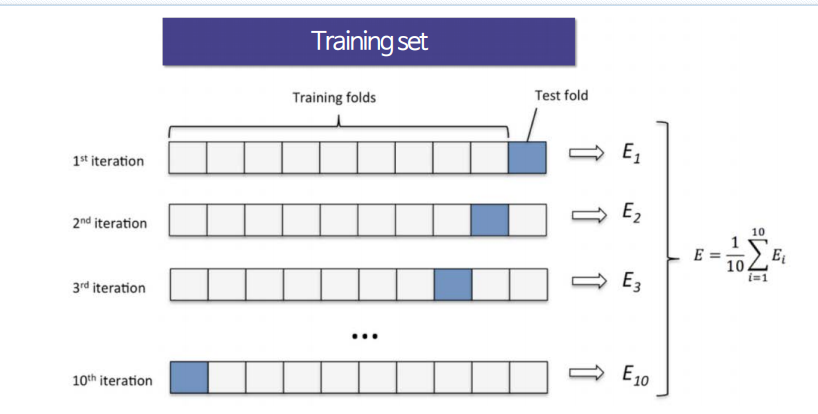

In [73]:
from sklearn.metrics import accuracy_score

for train_idx, test_idx in kfold.split(X_ss):
  X_train, X_test = X_ss[train_idx], X_ss[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  log_reg_kf.fit(X_train,y_train)

  pred = log_reg_kf.predict(X_test)
  accuracy = accuracy_score(y_test,pred)

  cv_accuracy.append(accuracy)

In [74]:
cv_accuracy

[0.7703349282296651,
 0.8708133971291866,
 0.8229665071770335,
 0.7464114832535885,
 0.7129186602870813]

In [75]:
import numpy as np

np.mean(cv_accuracy)
# 교차 검증의 평균값

0.7846889952153109

In [76]:
for train_idx, test_idx in kfold.split(X_ss):
  X_train, X_test = X_ss[train_idx], X_ss[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  print(np.unique(y_test,return_counts = True))

(array([0, 1]), array([ 74, 135]))
(array([0, 1]), array([107, 102]))
(array([0, 1]), array([125,  84]))
(array([0, 1]), array([155,  54]))
(array([0, 1]), array([157,  52]))


위 교차검증에 대해서도, Label이 편향되도록 나누어져 있으므로, 공정하게 교차검증을 했다고 평가할 수 없다.
--> STRATIFIED KFOLD는 라벨의 불균형이 있을때 보존하기 위해 사용될 수 있다.

In [77]:
from sklearn.model_selection import StratifiedKFold

log_reg_kf = LogisticRegression(random_state = 13, solver = 'liblinear')
skfold = StratifiedKFold(n_splits = 5)
cv_accuracy = []

In [78]:
from sklearn.metrics import accuracy_score

for train_idx, test_idx in skfold.split(X_ss,y):
  X_train, X_test = X_ss[train_idx], X_ss[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  log_reg_kf.fit(X_train,y_train)

  pred = log_reg_kf.predict(X_test)
  accuracy = accuracy_score(y_test,pred)

  cv_accuracy.append(accuracy)

In [79]:
cv_accuracy

[0.569377990430622,
 0.861244019138756,
 0.8133971291866029,
 0.7320574162679426,
 0.6698564593301436]

In [80]:
for train_idx, test_idx in skfold.split(X_ss,y):
  X_train, X_test = X_ss[train_idx], X_ss[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  print(np.unique(y_test,return_counts = True))

(array([0, 1]), array([123,  86]))
(array([0, 1]), array([123,  86]))
(array([0, 1]), array([124,  85]))
(array([0, 1]), array([124,  85]))
(array([0, 1]), array([124,  85]))


In [81]:
np.mean(cv_accuracy)

0.7291866028708134

label을 균등하게 분배하여 교차검증을 하여도, 더 나은 성능이 아닐 수 있다. 

In [82]:
# 위의 교차검증을 한번에 처리하는 명령어도 제공됨 
from sklearn.model_selection import cross_val_score

scores = cross_val_score(log_reg_kf,X_ss,y,scoring = 'accuracy',cv = 5)

scores

array([0.56937799, 0.86124402, 0.81339713, 0.73205742, 0.66985646])

In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

SS = StandardScaler()
SS.fit(X)

X_ss = SS.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_ss,y,test_size = 0.2, random_state = 13)

In [84]:

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver = 'liblinear',random_state=13)
log_reg.fit(X_train,y_train) # 학습



pred_proba = log_reg.predict_proba(X_test)
#pred_proba는 2차원 배열로, [[사망확률, 생존확률], ....] 데이터를 담고 있다.

pred_proba_1 = pred_proba[:,1].reshape(-1,1) 
# 이를, 생존 확률만 가져와서(pred_proba[:,1]) reshape를 통해 2차원 배열로 만들어준다.
pred_proba_1[:5]

array([[0.08305646],
       [0.06758592],
       [0.10540686],
       [0.11586048],
       [0.53610571]])

In [85]:
from sklearn.preprocessing import Binarizer
# threshold 값을 기준으로 크면1 작으면 1으로 판단한다.

custom_threshold = 0.5

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)
custom_predict[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [1.]])

In [86]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print('Threshold : ',custom_threshold)
print('Accuracy : ',accuracy_score(y_test,custom_predict))
print('Precision : ',precision_score(y_test, custom_predict))
print('Recall : ', recall_score(y_test,custom_predict))

Threshold :  0.5
Accuracy :  0.7559808612440191
Precision :  0.7534246575342466
Recall :  0.625


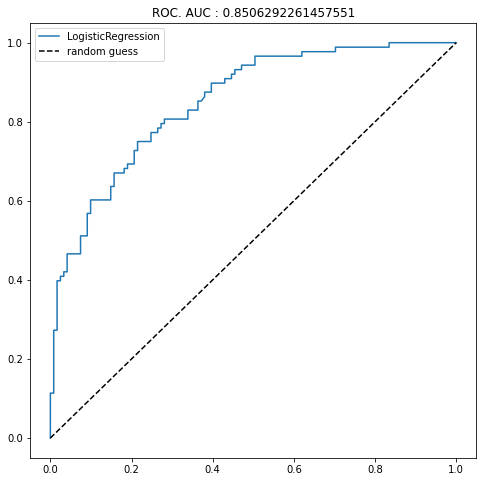

In [94]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

pred_proba_1 = log_reg.predict_proba(X_test)[:,1]
fpr ,tpr, thresholds = roc_curve(y_test,pred_proba_1)


plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, label = 'LogisticRegression')

plt.plot([0,1],[0,1],'k--',label= 'random guess')
plt.title("ROC. AUC : "+str(roc_auc_score(y_test,pred_proba_1)))
plt.legend()
plt.show()